# Figure 1. Mosquito dynamics of Wolbachia replacement
Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 28 Sep 22

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0 #0.11    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5      # mating competitiveness of released wolbachia males
e = 1.2      # relative mortality of wolbachia adults compared to wild adults
RR = 0.02915       # release ratio of wolbachia eggs to wild type eggs

Initial conditions:
(equilibrium values previously defined in Supp)

In [3]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
M0 = 228.72754035145144
MW0 = 0
F0 = 228.72754035145144
FW0 = 0

Wolbachia release function:

In [4]:
fN = 14                        #frequency of new Wol release
start_N = 139                   #day to first deploy Wol 
stop_N = 253                   #stop deploying wolbachia - 253 is 9 releases, 330 is 14 releases

def pulseN(t):
    if round(t) < start_N:     #start releases
        return 0
    elif round(t) % fN > 0:    #do it every fN days i.e. if modulus is anything but zero do nothing
        return 0
    elif round(t) > stop_N:    #stop releases
        return 0
    else:
        return O0 #15947.608023052446 equilibrium

Wolbachia model:

In [5]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN):
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = y
    
    #MOSQUITOES
    
    allmales = 1+M+MW
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = phi * F_nothing * M_nothing/allmales - alphaO*O - muO*O
    # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = phi * F_wol - alphaO*OW - muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW 
        
    #Larvae
    dLdt =  alphaO*O - alphaL*L - muL*L 
    dLWdt = alphaO*OW - alphaL*LW - muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    
    #Pupae
    dPdt =  alphaL*(L/(1+((AA*(L+LW))**BB))) - alphaP*P - muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW))**BB))) - alphaP*PW - muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    
    #Adult
    dMdt = 0.5*alphaP*P - muM*M
    dMWdt = 0.5*alphaP*(PW+rPW) - muM*MW*e
    
    dFdt = 0.5*alphaP*P - muF*F
    dFWdt = 0.5*alphaP*(PW+rPW) - muF*FW*e  

    return dOdt, dOWdt, drOWdt, dLdt, dLWdt, drLWdt, dPdt, dPWdt, drPWdt,  dMdt, dMWdt, dFdt, dFWdt

Model prerequisites:

In [6]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, L0, LW0, rLW0, P0, PW0, rPW0, M0, MW0, F0, FW0 # initial condition vector

### 2. Panels A & B; population dynamics of 9 and 14 releases
Run model:

In [7]:
# 9 RELEASES

stop_N = 253

fix9 = []
bump9 = [["Release number","Population increase"]]
pop9 = []
rr_index = [0.0296, 0.0507, 0.0775, 0.1098, 0.1478, 0.1915, 0.2405, 0.2953]
for j in rr_index:
    RR = j
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    wildtotal = M+F
    total = MW+FW+M+F
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95) #time of fixation from start of model
    y = M[z]+MW[z]+F[z]+FW[z] #total population at time of fixation
    
    popeq = M[0]+MW[0]+F[0]+FW[0] 
    popmax = max(M+MW+F+FW)
    bump = popmax-popeq
    
    fix9.append((z,y))
    bump9.append([j,bump])
    pop9.append(total)
    
fix9days = [] #time of fixation from first release
for j in range(0,len(fix9)):
    fix9days.append(fix9[j][0] - 140)

Plot:

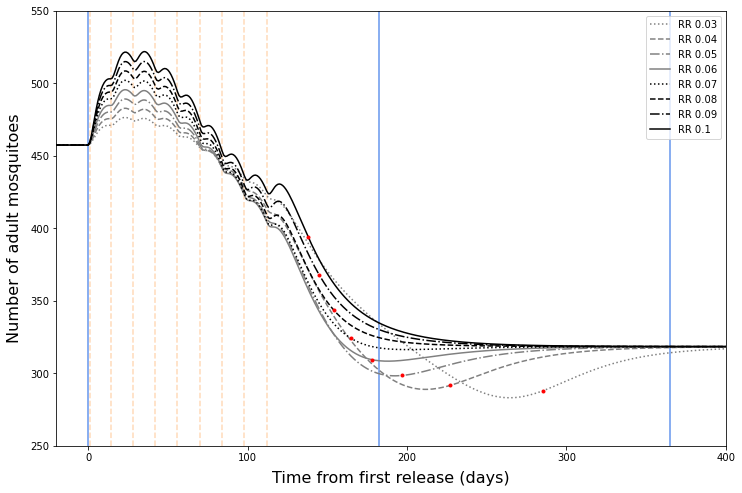

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.margins(x=0, y=0)
plt.axvline(x=140, color="cornflowerblue", linestyle="solid")
plt.axvline(x=322.5, color="cornflowerblue", linestyle="solid")
plt.axvline(x=505, color="cornflowerblue", linestyle="solid")
plt.axvline(x=140+1, color="peachpuff", linestyle="dashed")
plt.axvline(x=154, color="peachpuff", linestyle="dashed")
plt.axvline(x=168, color="peachpuff", linestyle="dashed")
plt.axvline(x=182, color="peachpuff", linestyle="dashed")
plt.axvline(x=196, color="peachpuff", linestyle="dashed")
plt.axvline(x=210, color="peachpuff", linestyle="dashed")
plt.axvline(x=224, color="peachpuff", linestyle="dashed")
plt.axvline(x=238, color="peachpuff", linestyle="dashed")
plt.axvline(x=252, color="peachpuff", linestyle="dashed")
ax.plot(t, pop9[0], 'grey', linestyle='dotted', label='RR 0.03')
ax.plot(fix9[0][0], fix9[0][1], marker=".", color="red")
ax.plot(t, pop9[1], 'grey', linestyle='dashed', label='RR 0.04')
ax.plot(fix9[1][0], fix9[1][1], marker=".", color="red")
ax.plot(t, pop9[2], 'grey', linestyle='dashdot', label='RR 0.05')
ax.plot(fix9[2][0], fix9[2][1], marker=".", color="red")
ax.plot(t, pop9[3], 'grey', linestyle='solid', label='RR 0.06')
ax.plot(fix9[3][0], fix9[3][1], marker=".", color="red")
ax.plot(t, pop9[4], 'black', linestyle='dotted', label='RR 0.07')
ax.plot(fix9[4][0], fix9[4][1], marker=".", color="red")
ax.plot(t, pop9[5], 'black', linestyle='dashed', label='RR 0.08')
ax.plot(fix9[5][0], fix9[5][1], marker=".", color="red")
ax.plot(t, pop9[6], 'black', linestyle='dashdot', label='RR 0.09')
ax.plot(fix9[6][0], fix9[6][1], marker=".", color="red")
ax.plot(t, pop9[7], 'black', linestyle='solid', label='RR 0.1')
ax.plot(fix9[7][0], fix9[7][1], marker=".", color="red")

positions1 = (140, 240, 340, 440, 540)
labels1 = ("0", "100", "200", "300", "400")
plt.xticks(positions1, labels1)
ax.set_xlim([120, 540])
ax.set_ylim([250, 550])
ax.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax.legend(loc = 'upper right')
#ax.set_title("Nine Releases")

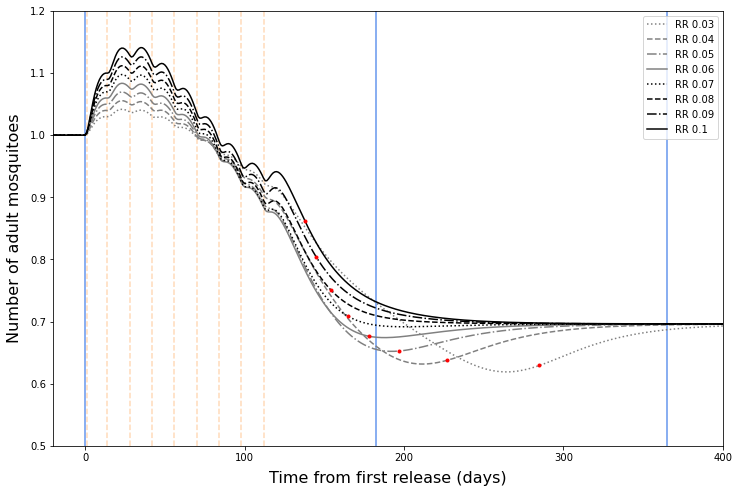

In [9]:
# ALTERNATE PLOT y-axis proportional to no control
equilibrium = 457.4550807029029

fig, ax = plt.subplots(figsize=(12, 8))

plt.margins(x=0, y=0)
plt.axvline(x=140, color="cornflowerblue", linestyle="solid")
plt.axvline(x=322.5, color="cornflowerblue", linestyle="solid")
plt.axvline(x=505, color="cornflowerblue", linestyle="solid")
plt.axvline(x=140+1, color="peachpuff", linestyle="dashed")
plt.axvline(x=154, color="peachpuff", linestyle="dashed")
plt.axvline(x=168, color="peachpuff", linestyle="dashed")
plt.axvline(x=182, color="peachpuff", linestyle="dashed")
plt.axvline(x=196, color="peachpuff", linestyle="dashed")
plt.axvline(x=210, color="peachpuff", linestyle="dashed")
plt.axvline(x=224, color="peachpuff", linestyle="dashed")
plt.axvline(x=238, color="peachpuff", linestyle="dashed")
plt.axvline(x=252, color="peachpuff", linestyle="dashed")
ax.plot(t, pop9[0]/equilibrium, 'grey', linestyle='dotted', label='RR 0.03')
ax.plot(fix9[0][0], fix9[0][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[1]/equilibrium, 'grey', linestyle='dashed', label='RR 0.04')
ax.plot(fix9[1][0], fix9[1][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[2]/equilibrium, 'grey', linestyle='dashdot', label='RR 0.05')
ax.plot(fix9[2][0], fix9[2][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[3]/equilibrium, 'grey', linestyle='solid', label='RR 0.06')
ax.plot(fix9[3][0], fix9[3][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[4]/equilibrium, 'black', linestyle='dotted', label='RR 0.07')
ax.plot(fix9[4][0], fix9[4][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[5]/equilibrium, 'black', linestyle='dashed', label='RR 0.08')
ax.plot(fix9[5][0], fix9[5][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[6]/equilibrium, 'black', linestyle='dashdot', label='RR 0.09')
ax.plot(fix9[6][0], fix9[6][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[7]/equilibrium, 'black', linestyle='solid', label='RR 0.1')
ax.plot(fix9[7][0], fix9[7][1]/equilibrium, marker=".", color="red")

positions1 = (140, 240, 340, 440, 540)
labels1 = ("0", "100", "200", "300", "400")
plt.xticks(positions1, labels1)
ax.set_xlim([120, 540])
ax.set_ylim([0.5, 1.2])
ax.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax.legend(loc = 'upper right')
#ax.set_title("Nine Releases")

Run model:

In [10]:
# 14 RELEASES

stop_N = 323

fix14 = []
bump14 = [["Release number","Population increase"]]
pop14 = []
rr_index = [0.0296, 0.0507, 0.0775, 0.1098, 0.1478, 0.1915, 0.2405, 0.2953]
for j in rr_index:
    RR = j
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    total = MW+FW+M+F
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95) #time of fixation from start of model
    y = M[z]+MW[z]+F[z]+FW[z] #total population at time of fixation
    
    popeq = M[0]+MW[0]+F[0]+FW[0] 
    popmax = max(M+MW+F+FW)
    bump = popmax-popeq
    
    fix14.append((z,y))
    bump14.append([j,bump])
    pop14.append(total)

fix14days = [] #time of fixation from first release
for j in range(0,len(fix14)):
    fix14days.append(fix14[j][0] - 140)

Plot:

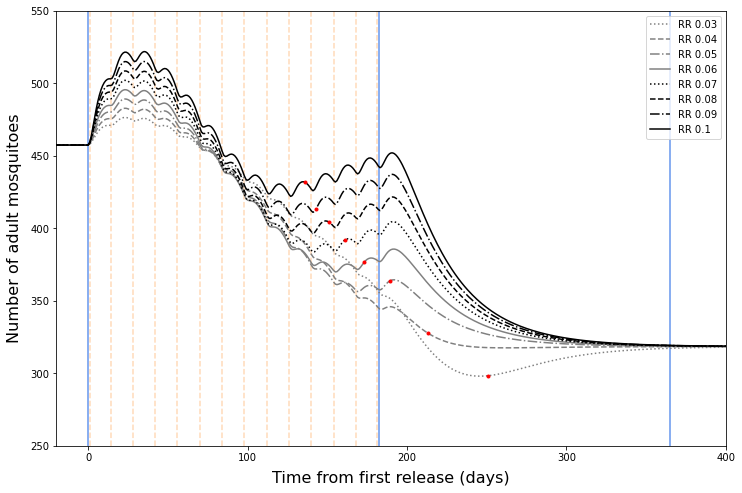

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.margins(x=0, y=0)
plt.axvline(x=140, color="cornflowerblue", linestyle="solid")
plt.axvline(x=322.5, color="cornflowerblue", linestyle="solid")
plt.axvline(x=505, color="cornflowerblue", linestyle="solid")
plt.axvline(x=140+1, color="peachpuff", linestyle="dashed")
plt.axvline(x=154, color="peachpuff", linestyle="dashed")
plt.axvline(x=168, color="peachpuff", linestyle="dashed")
plt.axvline(x=182, color="peachpuff", linestyle="dashed")
plt.axvline(x=196, color="peachpuff", linestyle="dashed")
plt.axvline(x=210, color="peachpuff", linestyle="dashed")
plt.axvline(x=224, color="peachpuff", linestyle="dashed")
plt.axvline(x=238, color="peachpuff", linestyle="dashed")
plt.axvline(x=252, color="peachpuff", linestyle="dashed")
plt.axvline(x=266, color="peachpuff", linestyle="dashed")
plt.axvline(x=280, color="peachpuff", linestyle="dashed")
plt.axvline(x=294, color="peachpuff", linestyle="dashed")
plt.axvline(x=308, color="peachpuff", linestyle="dashed")
plt.axvline(x=322-1, color="peachpuff", linestyle="dashed")
ax.plot(t, pop14[0], 'grey', linestyle='dotted', label='RR 0.03')
ax.plot(fix14[0][0], fix14[0][1], marker=".", color="red")
ax.plot(t, pop14[1], 'grey', linestyle='dashed', label='RR 0.04')
ax.plot(fix14[1][0], fix14[1][1], marker=".", color="red")
ax.plot(t, pop14[2], 'grey', linestyle='dashdot', label='RR 0.05')
ax.plot(fix14[2][0], fix14[2][1], marker=".", color="red")
ax.plot(t, pop14[3], 'grey', linestyle='solid', label='RR 0.06')
ax.plot(fix14[3][0], fix14[3][1], marker=".", color="red")
ax.plot(t, pop14[4], 'black', linestyle='dotted', label='RR 0.07')
ax.plot(fix14[4][0], fix14[4][1], marker=".", color="red")
ax.plot(t, pop14[5], 'black', linestyle='dashed', label='RR 0.08')
ax.plot(fix14[5][0], fix14[5][1], marker=".", color="red")
ax.plot(t, pop14[6], 'black', linestyle='dashdot', label='RR 0.09')
ax.plot(fix14[6][0], fix14[6][1], marker=".", color="red")
ax.plot(t, pop14[7], 'black', linestyle='solid', label='RR 0.1')
ax.plot(fix14[7][0], fix14[7][1], marker=".", color="red")
positions1 = (140, 240, 340, 440, 540)
labels1 = ("0", "100", "200", "300", "400")
plt.xticks(positions1, labels1)
ax.set_xlim([120, 540])
ax.set_ylim([250, 550])
ax.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax.legend(loc = 'upper right')
#ax.set_title("Fourteen Releases")

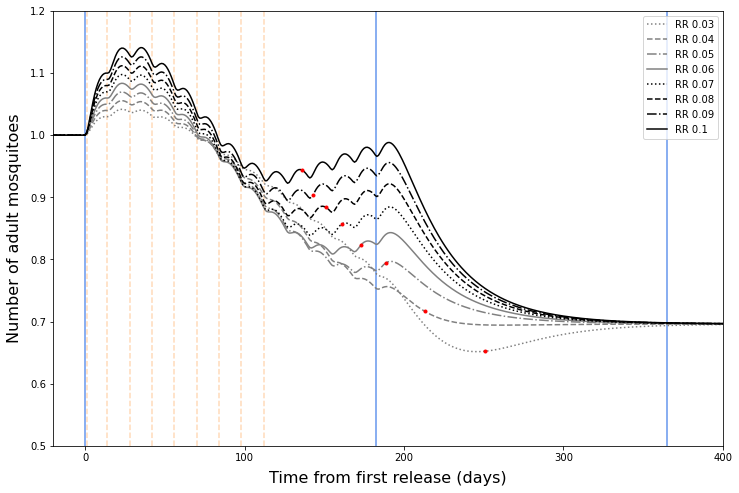

In [12]:
# ALTERNATE PLOT y-axis proportional to no control
equilibrium = 457.4550807029029

fig, ax = plt.subplots(figsize=(12, 8))

plt.margins(x=0, y=0)
plt.axvline(x=140, color="cornflowerblue", linestyle="solid")
plt.axvline(x=322.5, color="cornflowerblue", linestyle="solid")
plt.axvline(x=505, color="cornflowerblue", linestyle="solid")
plt.axvline(x=140+1, color="peachpuff", linestyle="dashed")
plt.axvline(x=154, color="peachpuff", linestyle="dashed")
plt.axvline(x=168, color="peachpuff", linestyle="dashed")
plt.axvline(x=182, color="peachpuff", linestyle="dashed")
plt.axvline(x=196, color="peachpuff", linestyle="dashed")
plt.axvline(x=210, color="peachpuff", linestyle="dashed")
plt.axvline(x=224, color="peachpuff", linestyle="dashed")
plt.axvline(x=238, color="peachpuff", linestyle="dashed")
plt.axvline(x=252, color="peachpuff", linestyle="dashed")
ax.plot(t, pop14[0]/equilibrium, 'grey', linestyle='dotted', label='RR 0.03')
ax.plot(fix14[0][0], fix14[0][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[1]/equilibrium, 'grey', linestyle='dashed', label='RR 0.04')
ax.plot(fix14[1][0], fix14[1][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[2]/equilibrium, 'grey', linestyle='dashdot', label='RR 0.05')
ax.plot(fix14[2][0], fix14[2][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[3]/equilibrium, 'grey', linestyle='solid', label='RR 0.06')
ax.plot(fix14[3][0], fix14[3][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[4]/equilibrium, 'black', linestyle='dotted', label='RR 0.07')
ax.plot(fix14[4][0], fix14[4][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[5]/equilibrium, 'black', linestyle='dashed', label='RR 0.08')
ax.plot(fix14[5][0], fix14[5][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[6]/equilibrium, 'black', linestyle='dashdot', label='RR 0.09')
ax.plot(fix14[6][0], fix14[6][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[7]/equilibrium, 'black', linestyle='solid', label='RR 0.1')
ax.plot(fix14[7][0], fix14[7][1]/equilibrium, marker=".", color="red")

positions1 = (140, 240, 340, 440, 540)
labels1 = ("0", "100", "200", "300", "400")
plt.xticks(positions1, labels1)
ax.set_xlim([120, 540])
ax.set_ylim([0.5, 1.2])
ax.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax.legend(loc = 'upper right')
#ax.set_title("Nine Releases")

### 3. Panel C; days to fixation compared to release number
RR model code:

In [13]:
# Adult RR 0.03

curve1 = []
index_set1 = range(14)

for j in index_set1[8:]:
    stop_N = 141+(j*14)
    RR = 0.0296
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95)
    
    curve1.append(z-140)

print(curve1)  

[285, 271, 262, 256, 253, 251]


In [14]:
# Adult RR 0.04

curve2 = []
index_set1  = range(14)

for j in index_set1[8:]:
    stop_N = 141+(j*14)
    RR = 0.0507
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95)
    
    curve2.append(z-140)

print(curve2)    

[227, 221, 217, 215, 214, 213]


In [15]:
# Adult RR 0.05

curve3 = []
index_set1 = range(14)

for j in index_set1[8:]:
    stop_N = 141+(j*14)
    RR = 0.0775
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95)
    
    curve3.append(z-140)

print(curve3)   

[197, 194, 192, 191, 190, 189]


In [16]:
# Adult RR 0.06

curve4 = []
index_set1 = range(14)

for j in index_set1[8:]:
    stop_N = 141+(j*14)
    RR = 0.1098
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95)
    
    curve4.append(z-140)

print(curve4)    

[178, 176, 175, 173, 173, 173]


In [17]:
# Adult RR 0.07

curve5 = []
index_set1 = range(14)

for j in index_set1[8:]:
    stop_N = 141+(j*14)
    RR = 0.1478
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95)
    
    curve5.append(z-140)

print(curve5)  

[165, 163, 161, 161, 161, 161]


In [18]:
# Adult RR 0.08

curve6 = []
index_set1 = range(14)

for j in index_set1[8:]:
    stop_N = 141+(j*14)
    RR = 0.1915
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95)
    
    curve6.append(z-140)

print(curve6)    

[154, 152, 151, 151, 151, 151]


In [19]:
# Adult RR 0.09

curve7 = []
index_set1 = range(14)

for j in index_set1[8:]:
    stop_N = 141+(j*14)
    RR = 0.2405
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95)
    
    curve7.append(z-140)

print(curve7)   

[145, 144, 143, 143, 143, 143]


In [20]:
# Adult RR 0.1

curve8 = []
index_set1 = range(14)

for j in index_set1[8:]:
    stop_N = 141+(j*14)
    RR = 0.2953
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95)
    
    curve8.append(z-140)

print(curve8)   

[138, 136, 136, 136, 136, 136]


Plot:

([<matplotlib.axis.XTick at 0x7f9c71847e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 432x288 with 0 Axes>

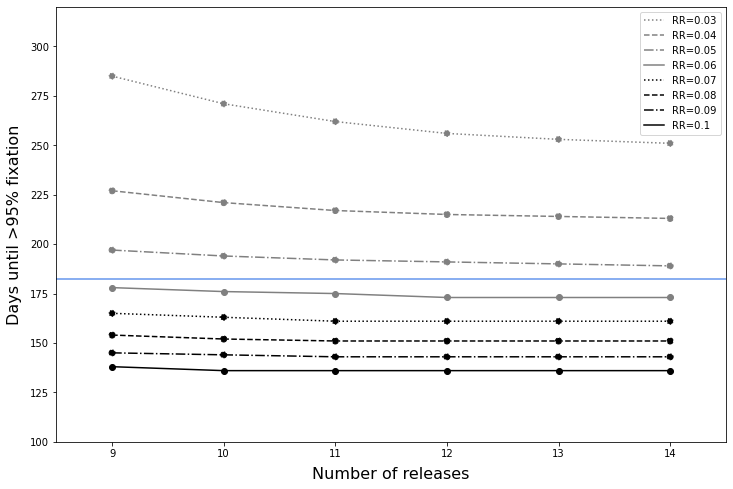

In [21]:
fig = plt.figure(facecolor=(1, 1, 1))
index_set = np.linspace(9,14,6)
plt.figure(figsize=(12, 8))

plt.scatter(index_set, curve1, color='grey', linestyle='dotted')
plt.plot(index_set, curve1, color='grey', linestyle='dotted', label="RR=0.03")

plt.scatter(index_set, curve2, color='grey', linestyle='dashed')
plt.plot(index_set, curve2, color='grey', linestyle='dashed', label="RR=0.04")

plt.scatter(index_set, curve3, color='grey', linestyle='dashdot')
plt.plot(index_set, curve3, color='grey', linestyle='dashdot', label="RR=0.05")

plt.scatter(index_set, curve4, color='grey', linestyle='solid')
plt.plot(index_set, curve4, color='grey', linestyle='solid', label="RR=0.06")

plt.scatter(index_set, curve5, color='black', linestyle='dotted')
plt.plot(index_set, curve5, color='black', linestyle='dotted', label="RR=0.07")

plt.scatter(index_set, curve6, color='black', linestyle='dashed')
plt.plot(index_set, curve6, color='black', linestyle='dashed', label="RR=0.08")

plt.scatter(index_set, curve7, color='black', linestyle='dashdot')
plt.plot(index_set, curve7, color='black', linestyle='dashdot', label="RR=0.09")

plt.scatter(index_set, curve8, color='black', linestyle='solid')
plt.plot(index_set, curve8, color='black', linestyle='solid', label="RR=0.1")

plt.legend(loc="upper right")
plt.ylabel('Days until >95% fixation', fontsize=16, labelpad=8)
plt.xlabel('Number of releases', fontsize=16, labelpad=8)
plt.axhline(y=182.5, color="cornflowerblue", linestyle="solid")
plt.axhline(y=365, color="cornflowerblue", linestyle="solid")
plt.axhline(y=547.5, color="cornflowerblue", linestyle="solid")
plt.axhline(y=730, color="cornflowerblue", linestyle="solid")
plt.ylim(100, 320)
plt.xlim(8.5,14.5)
plt.xticks([9,10,11,12,13,14])

([<matplotlib.axis.XTick at 0x7f9c6166e2b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 432x288 with 0 Axes>

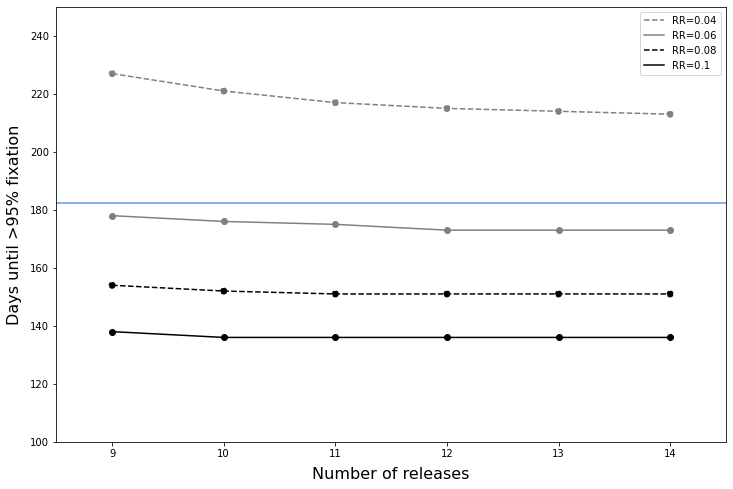

In [22]:
# ALTERNATE PLOT with only 4 lines

fig = plt.figure(facecolor=(1, 1, 1))
index_set = np.linspace(9,14,6)
plt.figure(figsize=(12, 8))

#plt.scatter(index_set, curve1, color='grey', linestyle='dotted')
#plt.plot(index_set, curve1, color='grey', linestyle='dotted', label="RR=0.03")

plt.scatter(index_set, curve2, color='grey', linestyle='dashed')
plt.plot(index_set, curve2, color='grey', linestyle='dashed', label="RR=0.04")

#plt.scatter(index_set, curve3, color='grey', linestyle='dashdot')
#plt.plot(index_set, curve3, color='grey', linestyle='dashdot', label="RR=0.05")

plt.scatter(index_set, curve4, color='grey', linestyle='solid')
plt.plot(index_set, curve4, color='grey', linestyle='solid', label="RR=0.06")

#plt.scatter(index_set, curve5, color='black', linestyle='dotted')
#plt.plot(index_set, curve5, color='black', linestyle='dotted', label="RR=0.07")

plt.scatter(index_set, curve6, color='black', linestyle='dashed')
plt.plot(index_set, curve6, color='black', linestyle='dashed', label="RR=0.08")

#plt.scatter(index_set, curve7, color='black', linestyle='dashdot')
#plt.plot(index_set, curve7, color='black', linestyle='dashdot', label="RR=0.09")

plt.scatter(index_set, curve8, color='black', linestyle='solid')
plt.plot(index_set, curve8, color='black', linestyle='solid', label="RR=0.1")

plt.legend(loc="upper right")
plt.ylabel('Days until >95% fixation', fontsize=16, labelpad=8)
plt.xlabel('Number of releases', fontsize=16, labelpad=8)
plt.axhline(y=182.5, color="cornflowerblue", linestyle="solid")
plt.axhline(y=365, color="cornflowerblue", linestyle="solid")
plt.axhline(y=547.5, color="cornflowerblue", linestyle="solid")
plt.axhline(y=730, color="cornflowerblue", linestyle="solid")
plt.ylim(100, 250)
plt.xlim(8.5,14.5)
plt.xticks([9,10,11,12,13,14])

### 4. Panel D; days to fixation compared to population increase
Missing release numbers model code:

In [23]:
# 10 RELEASES

stop_N = 267

fix10 = []
bump10 = [["Release number","Population increase"]]
pop10 = []
rr_index = [0.0296, 0.0507, 0.0775, 0.1098, 0.1478, 0.1915, 0.2405, 0.2953]
for j in rr_index:
    RR = j
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    total = MW+FW+M+F
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95) #time of fixation from start of model
    y = M[z]+MW[z]+F[z]+FW[z] #total population at time of fixation
    
    popeq = M[0]+MW[0]+F[0]+FW[0] 
    popmax = max(M+MW+F+FW)
    bump = popmax-popeq
    
    fix10.append((z,y))
    bump10.append([j,bump])
    pop10.append(total)

fix10days = [] #time of fixation from first release
for j in range(0,len(fix10)):
    fix10days.append(fix10[j][0] - 140)

In [24]:
# 11 RELEASES

stop_N = 281

fix11 = []
bump11 = [["Release number","Population increase"]]
pop11 = []
rr_index = [0.0296, 0.0507, 0.0775, 0.1098, 0.1478, 0.1915, 0.2405, 0.2953]
for j in rr_index:
    RR = j
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    total = MW+FW+M+F
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95) #time of fixation from start of model
    y = M[z]+MW[z]+F[z]+FW[z] #total population at time of fixation
    
    popeq = M[0]+MW[0]+F[0]+FW[0] 
    popmax = max(M+MW+F+FW)
    bump = popmax-popeq
    
    fix11.append((z,y))
    bump11.append([j,bump])
    pop11.append(total)
    
fix11days = [] #time of fixation from first release
for j in range(0,len(fix11)):
    fix11days.append(fix11[j][0] - 140)

In [25]:
# 12 RELEASES

stop_N = 295

fix12 = []
bump12 = [["Release number","Population increase"]]
pop12 = []
rr_index = [0.0296, 0.0507, 0.0775, 0.1098, 0.1478, 0.1915, 0.2405, 0.2953]
for j in rr_index:
    RR = j
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    total = MW+FW+M+F
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95) #time of fixation from start of model
    y = M[z]+MW[z]+F[z]+FW[z] #total population at time of fixation
    
    popeq = M[0]+MW[0]+F[0]+FW[0] 
    popmax = max(M+MW+F+FW)
    bump = popmax-popeq
    
    fix12.append((z,y))
    bump12.append([j,bump])
    pop12.append(total)
    
fix12days = [] #time of fixation from first release
for j in range(0,len(fix12)):
    fix12days.append(fix12[j][0] - 140)

In [26]:
# 13 RELEASES

stop_N = 309

fix13 = []
bump13 = [["Release number","Population increase"]]
pop13 = []
rr_index = [0.0296, 0.0507, 0.0775, 0.1098, 0.1478, 0.1915, 0.2405, 0.2953]
for j in rr_index:
    RR = j
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    total = MW+FW+M+F
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95) #time of fixation from start of model
    y = M[z]+MW[z]+F[z]+FW[z] #total population at time of fixation
    
    popeq = M[0]+MW[0]+F[0]+FW[0] 
    popmax = max(M+MW+F+FW)
    bump = popmax-popeq
    
    fix13.append((z,y))
    bump13.append([j,bump])
    pop13.append(total)
    
fix13days = [] #time of fixation from first release
for j in range(0,len(fix13)):
    fix13days.append(fix13[j][0] - 140)

Format model data and extract results:

In [27]:
# 9 RELEASES

pop9bump = []
for j in range(0,8):
    pop9bump.append(bump9[j+1][1]/457) #% change of initial bump

fix9days_2 = []
for j in range(0,8):
    fix9days_2.append(fix9[j][0]) #days to fixation

fix9pop = []
for j in range(0,8):
    fix9pop.append(fix9[j][1]) #pop at fixation
    
fix9days_array = [[0,fix9days_2[0]], #0.03
             [1,fix9days_2[1]],
             [2,fix9days_2[2]],
             [3,fix9days_2[3]],
             [4,fix9days_2[4]],
             [5,fix9days_2[5]],
             [6,fix9days_2[6]],
             [7,fix9days_2[7]]] #0.1
    
fix9pop_array = [[0,fix9pop[0]], #0.03
             [1,fix9pop[1]],
             [2,fix9pop[2]],
             [3,fix9pop[3]],
             [4,fix9pop[4]],
             [5,fix9pop[5]],
             [6,fix9pop[6]],
             [7,fix9pop[7]]] #0.1

pop9max = []
for j in fix9days_array:
    pop9max.append(max(pop9[j[0]][j[1]:])) #max pop after fixation

pop9max_bump = []
for j in fix9pop_array:
    pop9max_bump.append((pop9max[j[0]]-j[1])/j[1]) #% change from fixation population

for j in range(0,8):
    if pop9max_bump[j] <= 0:
        pop9max_bump[j] = 0
        index_neg = j
        for i in range(0,index_neg):
            pop9max_bump[i] = 0 #all negative % changes and values prior to that are 0
    
pop9_totalbump = []
for j in range(0,8):
    pop9_totalbump.append(pop9max_bump[j] + pop9bump[j])
pop9_totalbump    # combined total exacerbation %

[0.041671815411661685,
 0.05557921509803468,
 0.06959277492547561,
 0.0836090138550617,
 0.09771789038270529,
 0.11190487162320657,
 0.1261295250677909,
 0.1411229232464864]

In [28]:
# 10 RELEASES

pop10bump = []
for j in range(0,8):
    pop10bump.append(bump10[j+1][1]/457) #% change of initial bump

fix10days_2 = []
for j in range(0,8):
    fix10days_2.append(fix10[j][0]) #days to fixation

fix10pop = []
for j in range(0,8):
    fix10pop.append(fix10[j][1]) #pop at fixation
    
fix10days_array = [[0,fix10days_2[0]], #0.03
             [1,fix10days_2[1]],
             [2,fix10days_2[2]],
             [3,fix10days_2[3]],
             [4,fix10days_2[4]],
             [5,fix10days_2[5]],
             [6,fix10days_2[6]],
             [7,fix10days_2[7]]] #0.1
    
fix10pop_array = [[0,fix10pop[0]], #0.03
             [1,fix10pop[1]],
             [2,fix10pop[2]],
             [3,fix10pop[3]],
             [4,fix10pop[4]],
             [5,fix10pop[5]],
             [6,fix10pop[6]],
             [7,fix10pop[7]]] #0.1

pop10max = []
for j in fix10days_array:
    pop10max.append(max(pop10[j[0]][j[1]:])) #max pop after fixation

pop10max_bump = []
for j in fix10pop_array:
    pop10max_bump.append((pop10max[j[0]]-j[1])/j[1]) #% change from fixation population

for j in range(0,8):
    if pop10max_bump[j] <= 0:
        pop10max_bump[j] = 0
        index_neg = j
        for i in range(0,index_neg):
            pop10max_bump[i] = 0 #all negative % changes and values prior to that are 0
    
pop10_totalbump = []
for j in range(0,8):
    pop10_totalbump.append(pop10max_bump[j] + pop10bump[j])
pop10_totalbump    # combined total exacerbation %

[0.041671815411661685,
 0.05557921509803468,
 0.06959277492547561,
 0.0836090138550617,
 0.09771789038270529,
 0.11190487162320657,
 0.1261295250677909,
 0.14112292324648654]

In [29]:
# 11 RELEASES

pop11bump = []
for j in range(0,8):
    pop11bump.append(bump11[j+1][1]/457) #% change of initial bump

fix11days_2 = []
for j in range(0,8):
    fix11days_2.append(fix11[j][0]) #days to fixation

fix11pop = []
for j in range(0,8):
    fix11pop.append(fix11[j][1]) #pop at fixation
    
fix11days_array = [[0,fix11days_2[0]], #0.03
             [1,fix11days_2[1]],
             [2,fix11days_2[2]],
             [3,fix11days_2[3]],
             [4,fix11days_2[4]],
             [5,fix11days_2[5]],
             [6,fix11days_2[6]],
             [7,fix11days_2[7]]] #0.1
    
fix11pop_array = [[0,fix11pop[0]], #0.03
             [1,fix11pop[1]],
             [2,fix11pop[2]],
             [3,fix11pop[3]],
             [4,fix11pop[4]],
             [5,fix11pop[5]],
             [6,fix11pop[6]],
             [7,fix11pop[7]]] #0.1

pop11max = []
for j in fix11days_array:
    pop11max.append(max(pop11[j[0]][j[1]:])) #max pop after fixation

pop11max_bump = []
for j in fix11pop_array:
    pop11max_bump.append((pop11max[j[0]]-j[1])/j[1]) #% change from fixation population

for j in range(0,8):
    if pop11max_bump[j] <= 0:
        pop11max_bump[j] = 0
        index_neg = j
        for i in range(0,index_neg):
            pop11max_bump[i] = 0 #all negative % changes and values prior to that are 0
    
pop11_totalbump = []
for j in range(0,8):
    pop11_totalbump.append(pop11max_bump[j] + pop11bump[j])
pop11_totalbump    # combined total exacerbation %

[0.041671815411661685,
 0.05557921509803468,
 0.06959277492547561,
 0.0836090138550617,
 0.09771789038270529,
 0.11190487162320657,
 0.14528911371819925,
 0.15474602728736256]

In [30]:
# 12 RELEASES

pop12bump = []
for j in range(0,8):
    pop12bump.append(bump12[j+1][1]/457) #% change of initial bump

fix12days_2 = []
for j in range(0,8):
    fix12days_2.append(fix12[j][0]) #days to fixation

fix12pop = []
for j in range(0,8):
    fix12pop.append(fix12[j][1]) #pop at fixation
    
fix12days_array = [[0,fix12days_2[0]], #0.03
             [1,fix12days_2[1]],
             [2,fix12days_2[2]],
             [3,fix12days_2[3]],
             [4,fix12days_2[4]],
             [5,fix12days_2[5]],
             [6,fix12days_2[6]],
             [7,fix12days_2[7]]] #0.1
    
fix12pop_array = [[0,fix12pop[0]], #0.03
             [1,fix12pop[1]],
             [2,fix12pop[2]],
             [3,fix12pop[3]],
             [4,fix12pop[4]],
             [5,fix12pop[5]],
             [6,fix12pop[6]],
             [7,fix12pop[7]]] #0.1

pop12max = []
for j in fix12days_array:
    pop12max.append(max(pop12[j[0]][j[1]:])) #max pop after fixation

pop12max_bump = []
for j in fix12pop_array:
    pop12max_bump.append((pop12max[j[0]]-j[1])/j[1]) #% change from fixation population

for j in range(0,8):
    if pop12max_bump[j] <= 0:
        pop12max_bump[j] = 0
        index_neg = j
        for i in range(0,index_neg):
            pop12max_bump[i] = 0 #all negative % changes and values prior to that are 0
    
pop12_totalbump = []
for j in range(0,8):
    pop12_totalbump.append(pop12max_bump[j] + pop12bump[j])
pop12_totalbump    # combined total exacerbation %

[0.041671815411661685,
 0.05557921509803468,
 0.06959277492547561,
 0.0836090138550617,
 0.09981547182112219,
 0.12750780852172783,
 0.15998005008755278,
 0.16860430848546532]

In [31]:
# 13 RELEASES

pop13bump = []
for j in range(0,8):
    pop13bump.append(bump13[j+1][1]/457) #% change of initial bump

fix13days_2 = []
for j in range(0,8):
    fix13days_2.append(fix13[j][0]) #days to fixation

fix13pop = []
for j in range(0,8):
    fix13pop.append(fix13[j][1]) #pop at fixation
    
fix13days_array = [[0,fix13days_2[0]], #0.03
             [1,fix13days_2[1]],
             [2,fix13days_2[2]],
             [3,fix13days_2[3]],
             [4,fix13days_2[4]],
             [5,fix13days_2[5]],
             [6,fix13days_2[6]],
             [7,fix13days_2[7]]] #0.1
    
fix13pop_array = [[0,fix13pop[0]], #0.03
             [1,fix13pop[1]],
             [2,fix13pop[2]],
             [3,fix13pop[3]],
             [4,fix13pop[4]],
             [5,fix13pop[5]],
             [6,fix13pop[6]],
             [7,fix13pop[7]]] #0.1

pop13max = []
for j in fix13days_array:
    pop13max.append(max(pop13[j[0]][j[1]:])) #max pop after fixation

pop13max_bump = []
for j in fix13pop_array:
    pop13max_bump.append((pop13max[j[0]]-j[1])/j[1]) #% change from fixation population

for j in range(0,8):
    if pop13max_bump[j] <= 0:
        pop13max_bump[j] = 0
        index_neg = j
        for i in range(0,index_neg):
            pop13max_bump[i] = 0 #all negative % changes and values prior to that are 0
            
pop13_totalbump = []
for j in range(0,8):
    pop13_totalbump.append(pop13max_bump[j] + pop13bump[j])
pop13_totalbump    # combined total exacerbation %

[0.041671815411661685,
 0.05557921509803468,
 0.06959277492547561,
 0.09161135152717802,
 0.11511715012307025,
 0.14244073816861244,
 0.1733201928596559,
 0.17991647023737511]

In [32]:
# 14 RELEASES

pop14bump = []
for j in range(0,8):
    pop14bump.append(bump14[j+1][1]/457) #% change of initial bump

fix14days_2 = []
for j in range(0,8):
    fix14days_2.append(fix14[j][0]) #days to fixation

fix14pop = []
for j in range(0,8):
    fix14pop.append(fix14[j][1]) #pop at fixation
    
fix14days_array = [[0,fix14days_2[0]], #0.03
             [1,fix14days_2[1]],
             [2,fix14days_2[2]],
             [3,fix14days_2[3]],
             [4,fix14days_2[4]],
             [5,fix14days_2[5]],
             [6,fix14days_2[6]],
             [7,fix14days_2[7]]] #0.1
    
fix14pop_array = [[0,fix14pop[0]], #0.03
             [1,fix14pop[1]],
             [2,fix14pop[2]],
             [3,fix14pop[3]],
             [4,fix14pop[4]],
             [5,fix14pop[5]],
             [6,fix14pop[6]],
             [7,fix14pop[7]]] #0.1

pop14max = []
for j in fix14days_array:
    pop14max.append(max(pop14[j[0]][j[1]:])) #max pop after fixation

pop14max_bump = []
for j in fix14pop_array:
    pop14max_bump.append((pop14max[j[0]]-j[1])/j[1]) #% change from fixation population

for j in range(0,8):
    if pop14max_bump[j] <= 0:
        pop14max_bump[j] = 0
        index_neg = j
        for i in range(0,index_neg):
            pop14max_bump[i] = 0 #all negative % changes and values prior to that are 0
    
pop14_totalbump = []
for j in range(0,8):
    pop14_totalbump.append(pop14max_bump[j] + pop14bump[j])
pop14_totalbump    # combined total exacerbation %

[0.041671815411661685,
 0.05557921509803468,
 0.07198687998067252,
 0.10801880954305731,
 0.13002228989028777,
 0.1547635955312739,
 0.1833804843959565,
 0.18797673068155715]

Format into dataframe:

In [33]:
release_no = [range(9,15)]*8
release_no = list(chain.from_iterable(release_no)) #flatten

RR_vec = [0.03]*6,[0.04]*6,[0.05]*6,[0.06]*6,[0.07]*6,[0.08]*6,[0.09]*6,[0.1]*6
RR_vec = list(chain.from_iterable(RR_vec)) #flatten

bump_vec_pre = pop9_totalbump, pop10_totalbump, pop11_totalbump, pop12_totalbump, pop13_totalbump, pop14_totalbump
RR3bump = []
RR4bump = []
RR5bump = []
RR6bump = []
RR7bump = []
RR8bump = []
RR9bump = []
RR10bump = []
for j in range(0,6):
    RR3bump.append(bump_vec_pre[j][0])
    RR4bump.append(bump_vec_pre[j][1])
    RR5bump.append(bump_vec_pre[j][2])
    RR6bump.append(bump_vec_pre[j][3])
    RR7bump.append(bump_vec_pre[j][4])
    RR8bump.append(bump_vec_pre[j][5])
    RR9bump.append(bump_vec_pre[j][6])
    RR10bump.append(bump_vec_pre[j][7])
bump_vec_pre2 = RR3bump,RR4bump,RR5bump,RR6bump,RR7bump,RR8bump,RR9bump,RR10bump
bump_vec_pre2 = list(chain.from_iterable(bump_vec_pre2)) #flatten
bump_vec = []
for i in range(0,len(bump_vec_pre2)):
    bump_vec.append(bump_vec_pre2[i]*100)
    
days_fix_pre = fix9days_2,fix10days_2,fix11days_2,fix12days_2,fix13days_2,fix14days_2
RR3 = []
RR4 = []
RR5 = []
RR6 = []
RR7 = []
RR8 = []
RR9 = []
RR10 = []
for j in range(0,6):
    RR3.append(days_fix_pre[j][0])
    RR4.append(days_fix_pre[j][1])
    RR5.append(days_fix_pre[j][2])
    RR6.append(days_fix_pre[j][3])
    RR7.append(days_fix_pre[j][4])
    RR8.append(days_fix_pre[j][5])
    RR9.append(days_fix_pre[j][6])
    RR10.append(days_fix_pre[j][7])
days_fix = RR3, RR4, RR5, RR6, RR7, RR8, RR9, RR10
days_fix = list(chain.from_iterable(days_fix)) #flatten

df = pd.DataFrame({
    'noR':release_no,
    'RR':RR_vec,
    'exacerbation':bump_vec,
    'daysfix':days_fix})
df.head()

,noR,RR,exacerbation,daysfix
0,9,0.03,4.167182,425
1,10,0.03,4.167182,411
2,11,0.03,4.167182,402
3,12,0.03,4.167182,396
4,13,0.03,4.167182,393


Plot:

(0.0, 20.0)

<Figure size 432x288 with 0 Axes>

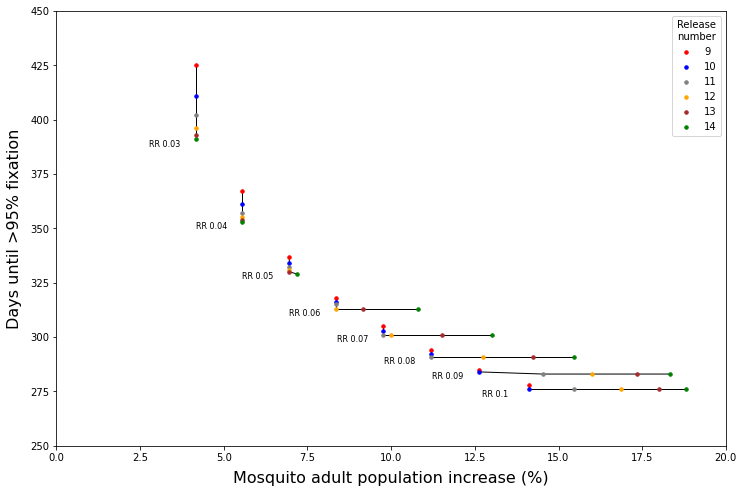

In [34]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.figure(figsize=(12, 8))

plt.plot(list(df.loc[df['RR'] == 0.03, 'exacerbation']), list(df.loc[df['RR'] == 0.03, 'daysfix']), color='black', linewidth=1, zorder=1)
plt.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.03, 'daysfix'])[0], color='red', label='9', s=12, zorder=7)
plt.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.03, 'daysfix'])[1], color='blue', label='10', s=12, zorder=6)
plt.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.03, 'daysfix'])[2], color='gray', label='11', s=12, zorder=5)
plt.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.03, 'daysfix'])[3], color='orange', label='12', s=12, zorder=4)
plt.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.03, 'daysfix'])[4], color='brown', label='13', s=12, zorder=3)
plt.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.03, 'daysfix'])[5], color='green', label='14', s=12, zorder=2)
plt.text(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[5]-1.4, list(df.loc[df['RR'] == 0.03, 'daysfix'])[5]-3.3, 'RR 0.03', fontsize=8)

plt.plot(list(df.loc[df['RR'] == 0.04, 'exacerbation']), list(df.loc[df['RR'] == 0.04, 'daysfix']), color='black', linewidth=1, zorder=1)
plt.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.04, 'daysfix'])[0], color='red', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.04, 'daysfix'])[1], color='blue', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.04, 'daysfix'])[2], color='gray', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.04, 'daysfix'])[3], color='orange', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.04, 'daysfix'])[4], color='brown', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.04, 'daysfix'])[5], color='green', s=12)
plt.text(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[5]-1.4, list(df.loc[df['RR'] == 0.04, 'daysfix'])[5]-3.3, 'RR 0.04', fontsize=8)

plt.plot(list(df.loc[df['RR'] == 0.05, 'exacerbation']), list(df.loc[df['RR'] == 0.05, 'daysfix']), color='black', linewidth=1, zorder=1)
plt.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.05, 'daysfix'])[0], color='red', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.05, 'daysfix'])[1], color='blue', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.05, 'daysfix'])[2], color='gray', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.05, 'daysfix'])[3], color='orange', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.05, 'daysfix'])[4], color='brown', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.05, 'daysfix'])[5], color='green', s=12)
plt.text(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[4]-1.4, list(df.loc[df['RR'] == 0.05, 'daysfix'])[4]-3.3, 'RR 0.05', fontsize=8)

plt.plot(list(df.loc[df['RR'] == 0.06, 'exacerbation']), list(df.loc[df['RR'] == 0.06, 'daysfix']), color='black', linewidth=1, zorder=1)
plt.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.06, 'daysfix'])[0], color='red', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.06, 'daysfix'])[1], color='blue', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.06, 'daysfix'])[2], color='gray', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.06, 'daysfix'])[3], color='orange', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.06, 'daysfix'])[4], color='brown', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.06, 'daysfix'])[5], color='green', s=12)
plt.text(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[3]-1.4, list(df.loc[df['RR'] == 0.06, 'daysfix'])[3]-3.3, 'RR 0.06', fontsize=8)

plt.plot(list(df.loc[df['RR'] == 0.07, 'exacerbation']), list(df.loc[df['RR'] == 0.07, 'daysfix']), color='black', linewidth=1, zorder=1)
plt.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.07, 'daysfix'])[0], color='red', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.07, 'daysfix'])[1], color='blue', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.07, 'daysfix'])[2], color='gray', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.07, 'daysfix'])[3], color='orange', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.07, 'daysfix'])[4], color='brown', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.07, 'daysfix'])[5], color='green', s=12)
plt.text(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[2]-1.4, list(df.loc[df['RR'] == 0.07, 'daysfix'])[2]-3.3, 'RR 0.07', fontsize=8)

plt.plot(list(df.loc[df['RR'] == 0.08, 'exacerbation']), list(df.loc[df['RR'] == 0.08, 'daysfix']), color='black', linewidth=1, zorder=1)
plt.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.08, 'daysfix'])[0], color='red', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.08, 'daysfix'])[1], color='blue', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.08, 'daysfix'])[2], color='gray', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.08, 'daysfix'])[3], color='orange', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.08, 'daysfix'])[4], color='brown', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.08, 'daysfix'])[5], color='green', s=12)
plt.text(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[2]-1.4, list(df.loc[df['RR'] == 0.08, 'daysfix'])[2]-3.3, 'RR 0.08', fontsize=8)

plt.plot(list(df.loc[df['RR'] == 0.09, 'exacerbation']), list(df.loc[df['RR'] == 0.09, 'daysfix']), color='black', linewidth=1, zorder=1)
plt.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.09, 'daysfix'])[0], color='red', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.09, 'daysfix'])[1], color='blue', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.09, 'daysfix'])[2], color='gray', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.09, 'daysfix'])[3], color='orange', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.09, 'daysfix'])[4], color='brown', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.09, 'daysfix'])[5], color='green', s=12)
plt.text(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[1]-1.4, list(df.loc[df['RR'] == 0.09, 'daysfix'])[1]-3.3, 'RR 0.09', fontsize=8)

plt.plot(list(df.loc[df['RR'] == 0.10, 'exacerbation']), list(df.loc[df['RR'] == 0.10, 'daysfix']), color='black', linewidth=1, zorder=1)
plt.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.10, 'daysfix'])[0], color='red', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.10, 'daysfix'])[1], color='blue', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.10, 'daysfix'])[2], color='gray', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.10, 'daysfix'])[3], color='orange', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.10, 'daysfix'])[4], color='brown', s=12)
plt.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.10, 'daysfix'])[5], color='green', s=12)
plt.text(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[1]-1.4, list(df.loc[df['RR'] == 0.10, 'daysfix'])[1]-3.3, 'RR 0.1', fontsize=8)

plt.legend(title="Release\nnumber", loc="upper right")
plt.ylabel('Days until >95% fixation', fontsize=16, labelpad=8)
plt.xlabel('Mosquito adult population increase (%)', fontsize=16, labelpad=8)
plt.ylim(250, 450)
plt.xlim(0,20)

### 5. Combine panels into one figure

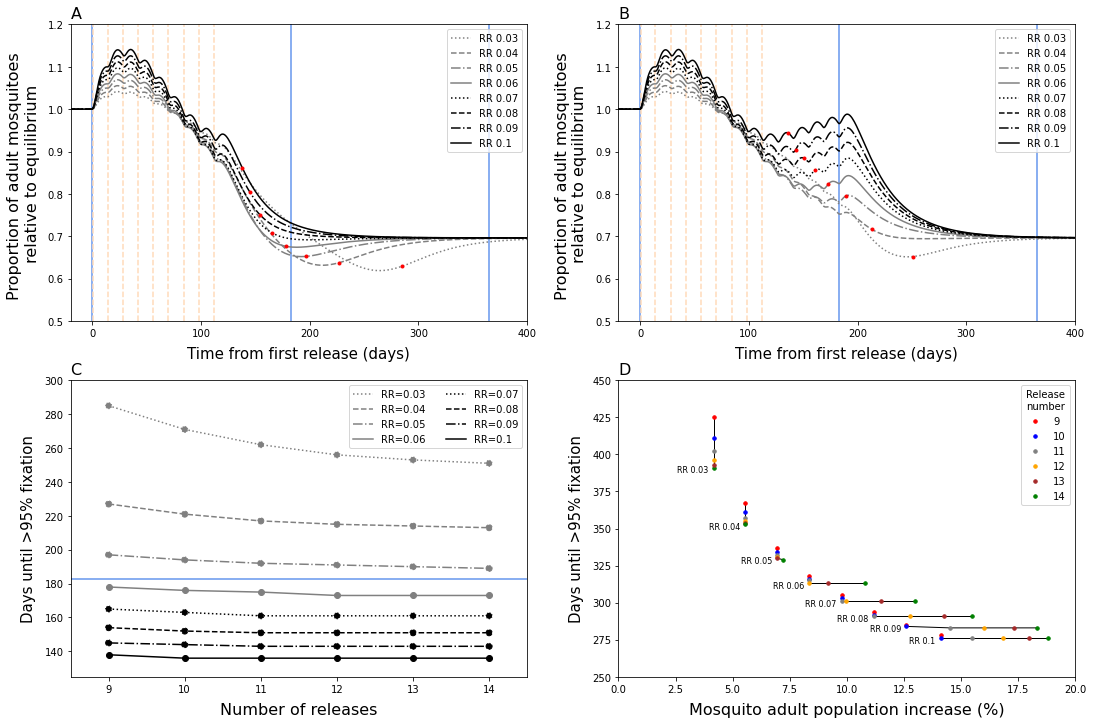

In [35]:
equilibrium = 457.4550807029029

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

ax1.margins(x=0, y=0)
ax1.axvline(x=140, color="cornflowerblue", linestyle="solid")
ax1.axvline(x=322.5, color="cornflowerblue", linestyle="solid")
ax1.axvline(x=505, color="cornflowerblue", linestyle="solid")
ax1.axvline(x=140+1, color="peachpuff", linestyle="dashed")
ax1.axvline(x=154, color="peachpuff", linestyle="dashed")
ax1.axvline(x=168, color="peachpuff", linestyle="dashed")
ax1.axvline(x=182, color="peachpuff", linestyle="dashed")
ax1.axvline(x=196, color="peachpuff", linestyle="dashed")
ax1.axvline(x=210, color="peachpuff", linestyle="dashed")
ax1.axvline(x=224, color="peachpuff", linestyle="dashed")
ax1.axvline(x=238, color="peachpuff", linestyle="dashed")
ax1.axvline(x=252, color="peachpuff", linestyle="dashed")
ax1.plot(t, pop9[0]/equilibrium, 'grey', linestyle='dotted', label='RR 0.03')
ax1.plot(fix9[0][0], fix9[0][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[1]/equilibrium, 'grey', linestyle='dashed', label='RR 0.04')
ax1.plot(fix9[1][0], fix9[1][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[2]/equilibrium, 'grey', linestyle='dashdot', label='RR 0.05')
ax1.plot(fix9[2][0], fix9[2][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[3]/equilibrium, 'grey', linestyle='solid', label='RR 0.06')
ax1.plot(fix9[3][0], fix9[3][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[4]/equilibrium, 'black', linestyle='dotted', label='RR 0.07')
ax1.plot(fix9[4][0], fix9[4][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[5]/equilibrium, 'black', linestyle='dashed', label='RR 0.08')
ax1.plot(fix9[5][0], fix9[5][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[6]/equilibrium, 'black', linestyle='dashdot', label='RR 0.09')
ax1.plot(fix9[6][0], fix9[6][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[7]/equilibrium, 'black', linestyle='solid', label='RR 0.1')
ax1.plot(fix9[7][0], fix9[7][1]/equilibrium, marker=".", color="red")

positions1 = (140, 240, 340, 440, 540)
labels1 = ("0", "100", "200", "300", "400")
ax1.set_xticks(positions1, labels1)
ax1.set_xlim([120, 540])
ax1.set_ylim([0.5, 1.2])
ax1.set_xlabel("Time from first release (days)", fontsize=15, labelpad=8)
ax1.set_ylabel("Proportion of adult mosquitoes \nrelative to equilibrium", fontsize=16, labelpad=8)
ax1.legend(loc = 'upper right')
ax1.set_title("A", loc='left', fontdict={'fontsize':16})

#---------------------

ax2.margins(x=0, y=0)
ax2.axvline(x=140, color="cornflowerblue", linestyle="solid")
ax2.axvline(x=322.5, color="cornflowerblue", linestyle="solid")
ax2.axvline(x=505, color="cornflowerblue", linestyle="solid")
ax2.axvline(x=140+1, color="peachpuff", linestyle="dashed")
ax2.axvline(x=154, color="peachpuff", linestyle="dashed")
ax2.axvline(x=168, color="peachpuff", linestyle="dashed")
ax2.axvline(x=182, color="peachpuff", linestyle="dashed")
ax2.axvline(x=196, color="peachpuff", linestyle="dashed")
ax2.axvline(x=210, color="peachpuff", linestyle="dashed")
ax2.axvline(x=224, color="peachpuff", linestyle="dashed")
ax2.axvline(x=238, color="peachpuff", linestyle="dashed")
ax2.axvline(x=252, color="peachpuff", linestyle="dashed")
ax2.axvline(x=266, color="peachpuff", linestyle="dashed")
ax2.axvline(x=280, color="peachpuff", linestyle="dashed")
ax2.axvline(x=294, color="peachpuff", linestyle="dashed")
ax2.axvline(x=308, color="peachpuff", linestyle="dashed")
ax2.axvline(x=322-1, color="peachpuff", linestyle="dashed")
ax2.plot(t, pop14[0]/equilibrium, 'grey', linestyle='dotted', label='RR 0.03')
ax2.plot(fix14[0][0], fix14[0][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[1]/equilibrium, 'grey', linestyle='dashed', label='RR 0.04')
ax2.plot(fix14[1][0], fix14[1][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[2]/equilibrium, 'grey', linestyle='dashdot', label='RR 0.05')
ax2.plot(fix14[2][0], fix14[2][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[3]/equilibrium, 'grey', linestyle='solid', label='RR 0.06')
ax2.plot(fix14[3][0], fix14[3][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[4]/equilibrium, 'black', linestyle='dotted', label='RR 0.07')
ax2.plot(fix14[4][0], fix14[4][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[5]/equilibrium, 'black', linestyle='dashed', label='RR 0.08')
ax2.plot(fix14[5][0], fix14[5][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[6]/equilibrium, 'black', linestyle='dashdot', label='RR 0.09')
ax2.plot(fix14[6][0], fix14[6][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[7]/equilibrium, 'black', linestyle='solid', label='RR 0.1')
ax2.plot(fix14[7][0], fix14[7][1]/equilibrium, marker=".", color="red")

ax2.set_xticks(positions1, labels1)
ax2.set_xlim([120, 540])
ax2.set_ylim([0.5, 1.2])
ax2.set_xlabel("Time from first release (days)", fontsize=15, labelpad=8)
ax2.set_ylabel("Proportion of adult mosquitoes \nrelative to equilibrium", fontsize=16, labelpad=8)
ax2.legend(loc = 'upper right')
ax2.set_title("B", loc='left', fontdict={'fontsize':16})

#---------------------

ax3.scatter(index_set, curve1, color='grey', linestyle='dotted')
ax3.plot(index_set, curve1, color='grey', linestyle='dotted', label="RR=0.03")
ax3.scatter(index_set, curve2, color='grey', linestyle='dashed')
ax3.plot(index_set, curve2, color='grey', linestyle='dashed', label="RR=0.04")
ax3.scatter(index_set, curve3, color='grey', linestyle='dashdot')
ax3.plot(index_set, curve3, color='grey', linestyle='dashdot', label="RR=0.05")
ax3.scatter(index_set, curve4, color='grey', linestyle='solid')
ax3.plot(index_set, curve4, color='grey', linestyle='solid', label="RR=0.06")
ax3.scatter(index_set, curve5, color='black', linestyle='dotted')
ax3.plot(index_set, curve5, color='black', linestyle='dotted', label="RR=0.07")
ax3.scatter(index_set, curve6, color='black', linestyle='dashed')
ax3.plot(index_set, curve6, color='black', linestyle='dashed', label="RR=0.08")
ax3.scatter(index_set, curve7, color='black', linestyle='dashdot')
ax3.plot(index_set, curve7, color='black', linestyle='dashdot', label="RR=0.09")
ax3.scatter(index_set, curve8, color='black', linestyle='solid')
ax3.plot(index_set, curve8, color='black', linestyle='solid', label="RR=0.1")

ax3.legend(loc="upper right", ncol=2)
ax3.set_ylabel('Days until >95% fixation', fontsize=15, labelpad=8)
ax3.set_xlabel('Number of releases', fontsize=16, labelpad=8)
ax3.axhline(y=182.5, color="cornflowerblue", linestyle="solid")
ax3.axhline(y=365, color="cornflowerblue", linestyle="solid")
ax3.axhline(y=547.5, color="cornflowerblue", linestyle="solid")
ax3.axhline(y=730, color="cornflowerblue", linestyle="solid")
ax3.set_ylim(125, 300)
ax3.set_xlim(8.5,14.5)
ax3.set_xticks([9,10,11,12,13,14])
ax3.set_title("C", loc='left', fontdict={'fontsize':16})

#---------------------

ax4.plot(list(df.loc[df['RR'] == 0.03, 'exacerbation']), list(df.loc[df['RR'] == 0.03, 'daysfix']), color='black', linewidth=1, zorder=1)
ax4.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.03, 'daysfix'])[0], color='red', label='9', s=12, zorder=7)
ax4.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.03, 'daysfix'])[1],  color='blue', label='10', s=12, zorder=6)
ax4.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.03, 'daysfix'])[2],  color='gray', label='11', s=12, zorder=5)
ax4.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.03, 'daysfix'])[3],  color='orange', label='12', s=12, zorder=4)
ax4.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.03, 'daysfix'])[4],  color='brown', label='13', s=12, zorder=3)
ax4.scatter(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.03, 'daysfix'])[5],  color='green', label='14', s=12, zorder=2)
ax4.text(list(df.loc[df['RR'] == 0.03, 'exacerbation'])[5]-1.6, list(df.loc[df['RR'] == 0.03, 'daysfix'])[5]-3.3, 'RR 0.03', fontsize=8)

ax4.plot(list(df.loc[df['RR'] == 0.04, 'exacerbation']), list(df.loc[df['RR'] == 0.04, 'daysfix']), color='black', linewidth=1, zorder=1)
ax4.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.04, 'daysfix'])[0], color='red', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.04, 'daysfix'])[1],  color='blue', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.04, 'daysfix'])[2],  color='gray', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.04, 'daysfix'])[3],  color='orange', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.04, 'daysfix'])[4],  color='brown', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.04, 'daysfix'])[5],  color='green', s=12)
ax4.text(list(df.loc[df['RR'] == 0.04, 'exacerbation'])[5]-1.6, list(df.loc[df['RR'] == 0.04, 'daysfix'])[5]-3.3, 'RR 0.04', fontsize=8)

ax4.plot(list(df.loc[df['RR'] == 0.05, 'exacerbation']), list(df.loc[df['RR'] == 0.05, 'daysfix']), color='black', linewidth=1, zorder=1)
ax4.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.05, 'daysfix'])[0], color='red', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.05, 'daysfix'])[1],  color='blue', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.05, 'daysfix'])[2],  color='gray', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.05, 'daysfix'])[3],  color='orange', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.05, 'daysfix'])[4],  color='brown', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.05, 'daysfix'])[5],  color='green', s=12)
ax4.text(list(df.loc[df['RR'] == 0.05, 'exacerbation'])[4]-1.6, list(df.loc[df['RR'] == 0.05, 'daysfix'])[4]-3.3, 'RR 0.05', fontsize=8)

ax4.plot(list(df.loc[df['RR'] == 0.06, 'exacerbation']), list(df.loc[df['RR'] == 0.06, 'daysfix']), color='black', linewidth=1, zorder=1)
ax4.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.06, 'daysfix'])[0], color='red', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.06, 'daysfix'])[1],  color='blue', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.06, 'daysfix'])[2],  color='gray', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.06, 'daysfix'])[3],  color='orange', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.06, 'daysfix'])[4],  color='brown', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.06, 'daysfix'])[5],  color='green', s=12)
ax4.text(list(df.loc[df['RR'] == 0.06, 'exacerbation'])[3]-1.6, list(df.loc[df['RR'] == 0.06, 'daysfix'])[3]-3.3, 'RR 0.06', fontsize=8)

ax4.plot(list(df.loc[df['RR'] == 0.07, 'exacerbation']), list(df.loc[df['RR'] == 0.07, 'daysfix']), color='black', linewidth=1, zorder=1)
ax4.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.07, 'daysfix'])[0], color='red', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.07, 'daysfix'])[1],  color='blue', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.07, 'daysfix'])[2],  color='gray', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.07, 'daysfix'])[3],  color='orange', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.07, 'daysfix'])[4],  color='brown', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.07, 'daysfix'])[5],  color='green', s=12)
ax4.text(list(df.loc[df['RR'] == 0.07, 'exacerbation'])[2]-1.6, list(df.loc[df['RR'] == 0.07, 'daysfix'])[2]-3.3, 'RR 0.07', fontsize=8)

ax4.plot(list(df.loc[df['RR'] == 0.08, 'exacerbation']), list(df.loc[df['RR'] == 0.08, 'daysfix']), color='black', linewidth=1, zorder=1)
ax4.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.08, 'daysfix'])[0], color='red', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.08, 'daysfix'])[1],  color='blue', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.08, 'daysfix'])[2],  color='gray', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.08, 'daysfix'])[3],  color='orange', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.08, 'daysfix'])[4],  color='brown', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.08, 'daysfix'])[5],  color='green', s=12)
ax4.text(list(df.loc[df['RR'] == 0.08, 'exacerbation'])[2]-1.6, list(df.loc[df['RR'] == 0.08, 'daysfix'])[2]-3.3, 'RR 0.08', fontsize=8)

ax4.plot(list(df.loc[df['RR'] == 0.09, 'exacerbation']), list(df.loc[df['RR'] == 0.09, 'daysfix']), color='black', linewidth=1, zorder=1)
ax4.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.09, 'daysfix'])[0], color='red', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.09, 'daysfix'])[1],  color='blue', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.09, 'daysfix'])[2],  color='gray', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.09, 'daysfix'])[3],  color='orange', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.09, 'daysfix'])[4],  color='brown', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.09, 'daysfix'])[5],  color='green', s=12)
ax4.text(list(df.loc[df['RR'] == 0.09, 'exacerbation'])[1]-1.6, list(df.loc[df['RR'] == 0.09, 'daysfix'])[1]-3.3, 'RR 0.09', fontsize=8)

ax4.plot(list(df.loc[df['RR'] == 0.10, 'exacerbation']), list(df.loc[df['RR'] == 0.10, 'daysfix']), color='black', linewidth=1, zorder=1)
ax4.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[0], list(df.loc[df['RR'] == 0.10, 'daysfix'])[0], color='red', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[1], list(df.loc[df['RR'] == 0.10, 'daysfix'])[1],  color='blue', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[2], list(df.loc[df['RR'] == 0.10, 'daysfix'])[2],  color='gray', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[3], list(df.loc[df['RR'] == 0.10, 'daysfix'])[3],  color='orange', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[4], list(df.loc[df['RR'] == 0.10, 'daysfix'])[4],  color='brown', s=12)
ax4.scatter(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[5], list(df.loc[df['RR'] == 0.10, 'daysfix'])[5],  color='green', s=12)
ax4.text(list(df.loc[df['RR'] == 0.10, 'exacerbation'])[1]-1.4, list(df.loc[df['RR'] == 0.10, 'daysfix'])[1]-3.3, 'RR 0.1', fontsize=8)

ax4.legend(title="Release\nnumber", loc="upper right")
ax4.set_ylabel('Days until >95% fixation', fontsize=15, labelpad=8)
ax4.set_xlabel('Mosquito adult population increase (%)', fontsize=16, labelpad=8)
ax4.set_ylim(250, 450)
ax4.set_xlim(0,20)
ax4.set_title("D", loc='left', fontdict={'fontsize':16})

#plt.savefig('Fig1.jpeg', bbox_inches='tight', dpi = 600)